# Similarity analysis

We want to determine if the different batch simulated data is able to capture the biological signal that is present in the original data:  How much of the real input data is captured in the simulated batch data?

In other words, we want to compare the representation of the real input data and the simulated batch data.  We will use **SVCCA** to compare these two representations.

Here, we apply Singular Vector Canonical Correlation Analysis [Raghu et al. 2017](https://arxiv.org/pdf/1706.05806.pdf) [(github)](https://github.com/google/svcca) to the UMAP and PCA representations of our batch 1 simulated dataset vs batch n simulated datasets.  The output of the SVCCA analysis is the SVCCA mean similarity score. This single number can be interpreted as a measure of similarity between our original data vs batched dataset.

Briefly, SVCCA uses Singular Value Decomposition (SVD) to extract the components explaining 99% of the variation. This is done to remove potential dimensions described by noise. Next, SVCCA performs a Canonical Correlation Analysis (CCA) on the SVD matrices to identify maximum correlations of linear combinations of both input matrices. The algorithm will identify the canonical correlations of highest magnitude across and within algorithms of the same dimensionality.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import ast
import pandas as pd
import numpy as np
import random
import glob
import umap
import pickle
import warnings
warnings.filterwarnings(action='ignore')

sys.path.append("../")

from sklearn.decomposition import PCA
from functions import cca_core
from plotnine import *
from numpy.random import seed
randomState = 123
seed(randomState)

In [2]:
# Load config file
config_file = "config_exp_2.txt"

d = {}
float_params = ["learning_rate", "kappa", "epsilon_std"]
str_params = ["analysis_name", "NN_architecture"]
lst_params = ["num_batches"]
with open(config_file) as f:
    for line in f:
        (name, val) = line.split()
        if name in float_params:
            d[name] = float(val)
        elif name in str_params:
            d[name] = str(val)
        elif name in lst_params:
            d[name] = ast.literal_eval(val)
        else:
            d[name] = int(val)

In [3]:
# Parameters
analysis_name = d["analysis_name"]
NN_architecture = d["NN_architecture"]
num_PCs = d["num_PCs"]
num_batches = d["num_batches"]

In [4]:
# Load data
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../.."))

simulated_data_file = os.path.join(
    base_dir,
    "data",
    "simulated",
    analysis_name,
    "simulated_data.txt.xz")

batch_dir = os.path.join(
    base_dir,
    "data",
    "batch_simulated",
    analysis_name)

umap_model_file = umap_model_file = os.path.join(
    base_dir,
    "models",  
    NN_architecture,
    "umap_model.pkl")

In [5]:
# Read in UMAP model
infile = open(umap_model_file, 'rb')
umap_model = pickle.load(infile)
infile.close()

In [6]:
# Read in data
simulated_data = pd.read_table(
    simulated_data_file,
    header=0, 
    index_col=0,
    sep='\t')

simulated_data.head(10)

,5340,339,244,1567,1827,4981,2310,3929,1498,3226,...,2787,2526,3299,3097,5330,2854,494,5089,3662,1920
0,0.535602,0.503128,0.285015,0.182251,0.338972,0.563961,0.324290,0.469941,0.185681,0.090720,...,0.544562,0.256521,0.326031,0.611043,0.412167,0.438068,0.280573,0.609067,0.402821,0.158164
1,0.602998,0.314449,0.170274,0.150126,0.393875,0.425789,0.359611,0.367097,0.162651,0.060858,...,0.558114,0.284270,0.290870,0.574704,0.281427,0.427374,0.250592,0.675274,0.470036,0.133792
2,0.517498,0.419739,0.182155,0.131460,0.324510,0.413850,0.320531,0.416758,0.152202,0.088437,...,0.792330,0.273688,0.418673,0.734889,0.254353,0.468174,0.249746,0.694683,0.476522,0.128183
3,0.397841,0.457606,0.323778,0.249936,0.297673,0.476715,0.381297,0.468330,0.215541,0.132116,...,0.590046,0.380182,0.329754,0.520238,0.422373,0.406375,0.207356,0.601750,0.407103,0.174844
4,0.535997,0.465947,0.277286,0.222062,0.385123,0.421842,0.330086,0.415129,0.177301,0.128083,...,0.557488,0.298452,0.395627,0.590282,0.290962,0.399933,0.272622,0.597588,0.440435,0.206779
5,0.493290,0.396501,0.249366,0.159639,0.375957,0.402583,0.275842,0.381382,0.261653,0.081041,...,0.688526,0.281114,0.452581,0.688948,0.270457,0.273857,0.142955,0.579213,0.546091,0.433394
6,0.433612,0.351818,0.241003,0.179525,0.336945,0.345377,0.321877,0.382335,0.167349,0.141031,...,0.629592,0.270185,0.363605,0.600325,0.337987,0.378784,0.203119,0.582426,0.467594,0.176376
7,0.451588,0.457565,0.336580,0.272774,0.264118,0.369123,0.275050,0.424156,0.250198,0.247813,...,0.390592,0.251810,0.273909,0.448068,0.424536,0.366531,0.295605,0.435115,0.335833,0.287866
8,0.619654,0.442385,0.281102,0.209915,0.417300,0.559756,0.303963,0.474562,0.233043,0.112126,...,0.427282,0.366223,0.458586,0.647082,0.318879,0.373176,0.295560,0.716585,0.483560,0.206377
9,0.434846,0.361911,0.255196,0.199091,0.345327,0.390971,0.342980,0.392987,0.176265,0.135802,...,0.615511,0.281425,0.373171,0.545738,0.388045,0.386622,0.230204,0.596523,0.427771,0.195655


## Calculate Similarity using PCA projection of batched data

In [7]:
%%time
# Calculate similarity using SVCCA

# Store svcca scores
output_list = []

for i in num_batches:
    print('Calculating SVCCA score for 1 batch vs {} batches..'.format(i))
    
    # Get batch 1
    batch_1_file = os.path.join(
        batch_dir,
        "Batch_1.txt.xz")

    batch_1 = pd.read_table(
        batch_1_file,
        header=0,
        sep='\t',
        index_col=0)

    # PCA projection
    pca = PCA(n_components=num_PCs)

    # Use trained model to encode expression data into SAME latent space
    original_data_PCAencoded = pca.fit_transform(batch_1)


    original_data_PCAencoded_df = pd.DataFrame(original_data_PCAencoded,
                                         index=batch_1.index
                                         )
    
    # All batches
    batch_other_file = os.path.join(
        batch_dir,
        "Batch_"+str(i)+".txt.xz")

    batch_other = pd.read_table(
        batch_other_file,
        header=0,
        sep='\t',
        index_col=0)
    
    print("Using batch {}".format(i))
    
    # Use trained model to encode expression data into SAME latent space
    batch_data_PCAencoded = pca.fit_transform(batch_other)
    
    
    batch_data_PCAencoded_df = pd.DataFrame(batch_data_PCAencoded,
                                         index=batch_other.index
                                         )
        
    # Check shape
    if original_data_PCAencoded_df.shape[0] != batch_data_PCAencoded_df.shape[0]:
        diff = original_data_PCAencoded_df.shape[0] - batch_data_PCAencoded_df.shape[0]
        original_data_PCAencoded_df = original_data_PCAencoded_df.iloc[:-diff,:]
    
    # SVCCA
    svcca_results = cca_core.get_cca_similarity(original_data_PCAencoded_df.T,
                                          batch_data_PCAencoded_df.T,
                                          verbose=False)
    
    output_list.append(np.mean(svcca_results["cca_coef1"]))

Calculating SVCCA score for 1 batch vs 1 batches..
Using batch 1
Calculating SVCCA score for 1 batch vs 2 batches..
Using batch 2
Calculating SVCCA score for 1 batch vs 5 batches..
Using batch 5
Calculating SVCCA score for 1 batch vs 10 batches..
Using batch 10
Calculating SVCCA score for 1 batch vs 20 batches..
Using batch 20
Calculating SVCCA score for 1 batch vs 50 batches..
Using batch 50
Calculating SVCCA score for 1 batch vs 100 batches..
Using batch 100
Calculating SVCCA score for 1 batch vs 500 batches..
Using batch 500
Calculating SVCCA score for 1 batch vs 1000 batches..
Using batch 1000
Calculating SVCCA score for 1 batch vs 2000 batches..
Using batch 2000
Calculating SVCCA score for 1 batch vs 3000 batches..
Using batch 3000
Calculating SVCCA score for 1 batch vs 6000 batches..
Using batch 6000
CPU times: user 9min 9s, sys: 42.5 s, total: 9min 51s
Wall time: 6min 58s


In [8]:
# Convert output to pandas dataframe
svcca_pca_df = pd.DataFrame(output_list, columns=["svcca_mean_similarity"], index=num_batches)
svcca_pca_df

,svcca_mean_similarity
1,0.998200
2,0.987315
5,0.959927
10,0.912505
20,0.819001
50,0.547357
100,0.138263
500,0.215909
1000,0.264298
2000,0.329643


In [9]:
%%time
# Permute simulated data
shuffled_simulated_arr = []
num_samples = simulated_data.shape[0]

for i in range(num_samples):
    row = list(simulated_data.values[i])
    shuffled_simulated_row = random.sample(row, len(row))
    shuffled_simulated_arr.append(shuffled_simulated_row)

shuffled_simulated_data = pd.DataFrame(shuffled_simulated_arr, 
                                       index=simulated_data.index, 
                                       columns=simulated_data.columns)
shuffled_simulated_data.head()

CPU times: user 26.5 s, sys: 396 ms, total: 26.9 s
Wall time: 26.7 s


In [10]:
%%time
# PCA
simulated_data_PCAencoded = pca.fit_transform(simulated_data)


simulated_data_PCAencoded_df = pd.DataFrame(simulated_data_PCAencoded,
                                     index=simulated_data.index
                                     )

shuffled_data_PCAencoded = pca.fit_transform(shuffled_simulated_data)


shuffled_data_PCAencoded_df = pd.DataFrame(shuffled_data_PCAencoded,
                                     index=shuffled_simulated_data.index
                                     )
 
# SVCCA
svcca_results = cca_core.get_cca_similarity(simulated_data_PCAencoded_df.T,
                                      shuffled_data_PCAencoded_df.T,
                                      verbose=False)

permuted_svcca = np.mean(svcca_results["cca_coef1"])
print(permuted_svcca)

0.12415921054647701
CPU times: user 15.4 s, sys: 3.27 s, total: 18.7 s
Wall time: 3.94 s


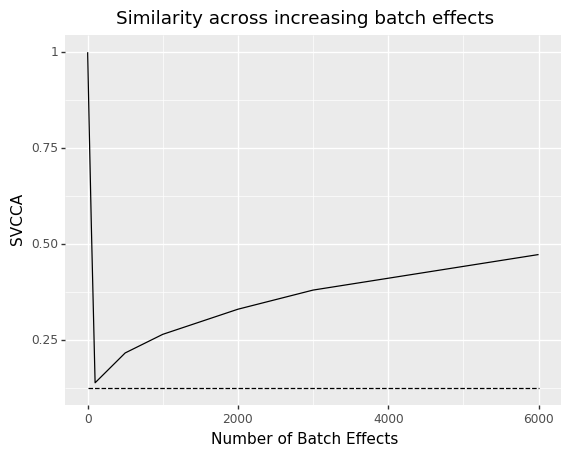

<ggplot: (-9223363259186189859)>

In [11]:
# Plot
threshold = pd.DataFrame(
    pd.np.tile(
        permuted_svcca,
        (len(num_batches), 1)),
    index=num_batches,
    columns=['svcca'])

ggplot(svcca_pca_df, aes(x=num_batches, y='svcca_mean_similarity')) \
    + geom_line() \
    + geom_line(aes(x=num_batches, y='svcca'), threshold, linetype='dashed') \
    + xlab('Number of Batch Effects') \
    + ylab('SVCCA') \
    + ggtitle('Similarity across increasing batch effects')